<a href="https://colab.research.google.com/github/ShimaaElabd/CNN-Classification-Fashion-MNIST/blob/master/Classify_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for Classification Fashion-MNIST:
---

* In this notebook, I define and train an CNN to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist). 

* This CNN with two convolutional layers and additional fully-connected and dropout layers to avoid overfitting the data and gradient descent with momentum to avoid reaching a local minimum.

## Load the [data](http://pytorch.org/docs/master/torchvision/datasets.html)

In this cell, data loaded in both **training and test** datasets from the FashionMNIST class.

In [4]:
# import basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [0]:
# prepare data loaders, set the batch_size

batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

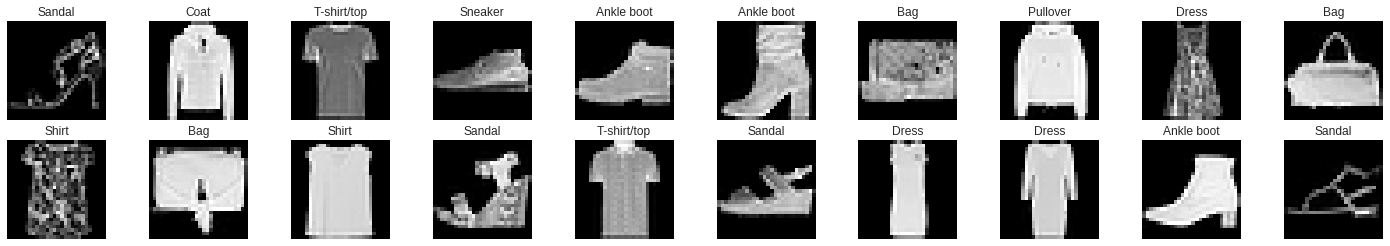

In [6]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html). For a convolutional neural network, will use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

Adding [dropout layers](http://pytorch.org/docs/stable/nn.html#dropout) to avoid overfitting this data.

---

To define a neural network in PyTorch, we define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below.

During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Place any layers with trainable weights, such as convolutional layers, in the `__init__` function and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, may appear *only* in the `forward` function. In practice, often see conv/pool layers defined in `__init__` and activations defined in `forward`.

#### Convolutional layer
It takes in a 1 channel (grayscale) image and outputs 10 feature maps as output, after convolving the image with 3x3 filters.

#### Flattening

To move from the output of a convolutional/pooling layer to a linear layer,  first flatten the extracted features into a vector. In Keras, this done by `Flatten()`, and in PyTorch, flatten an input `x` with `x = x.view(x.size(0), -1)`.

### Define the rest of the layers

* Use at least two convolutional layers
* Output must be a linear layer with 10 outputs (for the 10 classes of clothing)
* Use a dropout layer to avoid overfitting

### A note on output size

For any convolutional layer, the output feature maps will have the specified depth (a depth of 10 for 10 filters in a convolutional layer) and the dimensions of the produced feature maps (width/height) can be computed as the _input image_ width/height, W, minus the filter size, F, divided by the stride, S, all + 1. The equation looks like: `output_dim = (W-F)/S + 1`, for an assumed padding size of 0. Derivation of this formula, [here](http://cs231n.github.io/convolutional-networks/#conv).

For a pool layer with a size 2 and stride 2, the output dimension will be reduced by a factor of 2. 

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print the Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### Specify the loss function and optimizer

[loss functions](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizers](http://pytorch.org/docs/master/optim.html) in the online documentation.

For a classification problem like this, one typically uses cross entropy loss, which can be defined in code like: `criterion = nn.CrossEntropyLoss()`. PyTorch also includes some standard stochastic optimizers like stochastic gradient descent and Adam.


In [0]:
import torch.optim as optim

## specify loss function
# using cross entropy whcih combines softmax and NLL loss
criterion = nn.CrossEntropyLoss()

## specify optimizer 
# stochastic gradient descent with a small learning rate AND some momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### A note on accuracy

To look at the accuracy of your network **before and after** training to really identify that network has learned something. In the next cell, the accuracy of an untrained network is ( expect it to be around 10% which is the same accuracy as just guessing for all 11 classes).

In [9]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
# to convert `correct` from a Tensor into a scalar, use .item()
accuracy = 100.0 * correct.item() / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  10.4


### Train the Network

Below, defined a `train` function that takes in a number of epochs to train for. 
* The number of epochs is how many times a network will cycle through the entire training dataset. 
* Inside the epoch loop, we loop over the training dataset in batches; recording the loss every 1000 batches.

Here are the steps that this training function performs as it iterates over the training dataset:

1. Zero's the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss (how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network’s parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss

In [0]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [11]:
# define the number of epochs to train for
n_epochs = 2 # start small to see if model works, initially

# call train
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.7196515780687331
Epoch: 1, Batch: 2000, Avg. Loss: 0.9287875237762928
Epoch: 1, Batch: 3000, Avg. Loss: 0.8180442868918181
Epoch: 2, Batch: 1000, Avg. Loss: 0.7558811821937561
Epoch: 2, Batch: 2000, Avg. Loss: 0.6905601742565632
Epoch: 2, Batch: 3000, Avg. Loss: 0.6609727460443974
Finished Training


## Visualizing the loss

A good indication of how much the network is learning as it trains is the loss over time. so printed and recorded the average loss for each 1000 batches and for each epoch.And plot it and see how the loss decreases over time. 


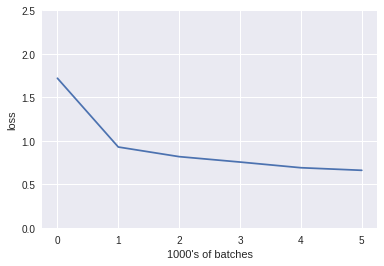

In [12]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

### Test the Trained Network


Test the trained model on a previously unseen dataset to see if it generalizes well and can accurately classify this new dataset. For FashionMNIST, which contains many pre-processed training images, a good model should reach **greater than 85% accuracy** on this test dataset. 

If not reaching this value, will  try training for a larger number of epochs, tweaking  hyperparameters, or adding/subtracting layers from the CNN.

In [13]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.577428

Test Accuracy of T-shirt/top: 75% (757/1000)
Test Accuracy of Trouser: 95% (953/1000)
Test Accuracy of Pullover: 66% (663/1000)
Test Accuracy of Dress: 76% (768/1000)
Test Accuracy of  Coat: 70% (707/1000)
Test Accuracy of Sandal: 91% (913/1000)
Test Accuracy of Shirt: 31% (317/1000)
Test Accuracy of Sneaker: 92% (926/1000)
Test Accuracy of   Bag: 92% (928/1000)
Test Accuracy of Ankle boot: 92% (923/1000)

Test Accuracy (Overall): 78% (7855/10000)


### Visualize sample test results

Format: predicted class (true class)

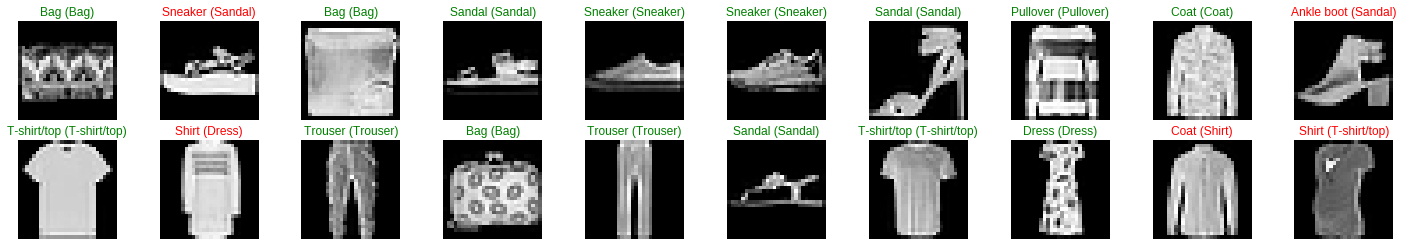

In [14]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [23]:
!pwd
!ls

/content
data  sample_data


In [0]:
# Saving the model
# after training, save the model parameters 
torch.save(net.state_dict(), 'fashion_net_ex.pt')